In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_compute_ktable =1

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

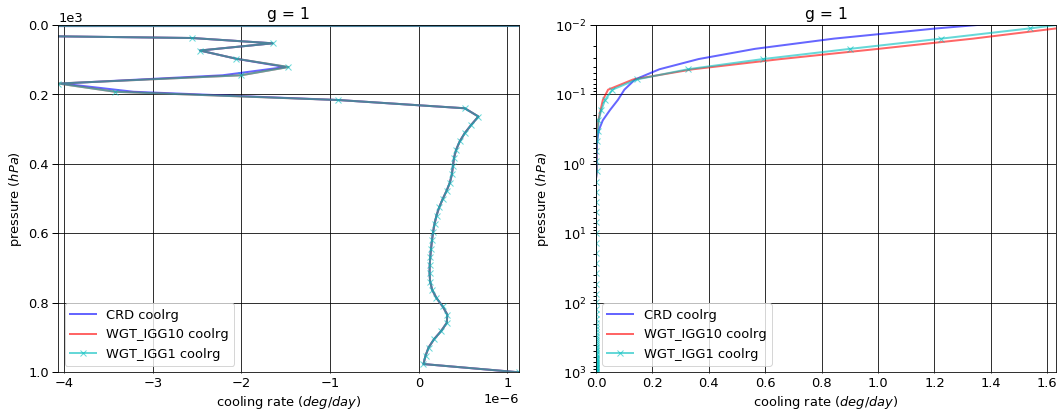

# Figure: cooling rate g-group 2

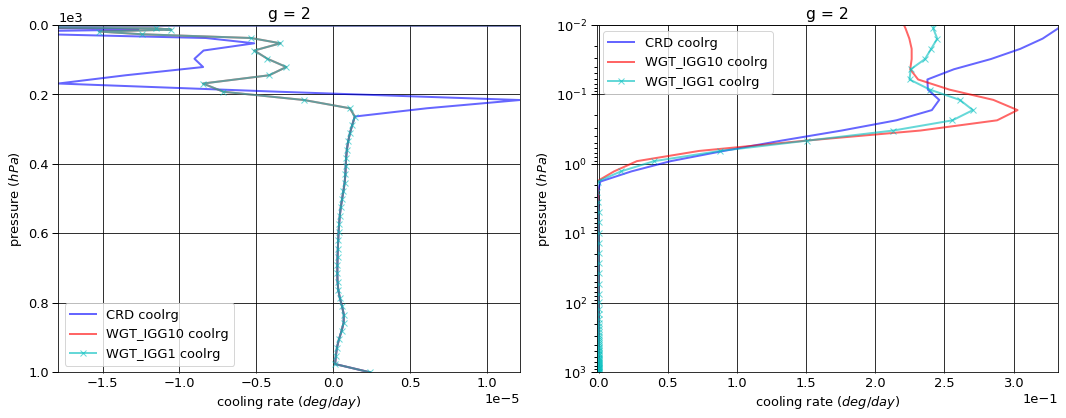

# Figure: cooling rate g-group 3

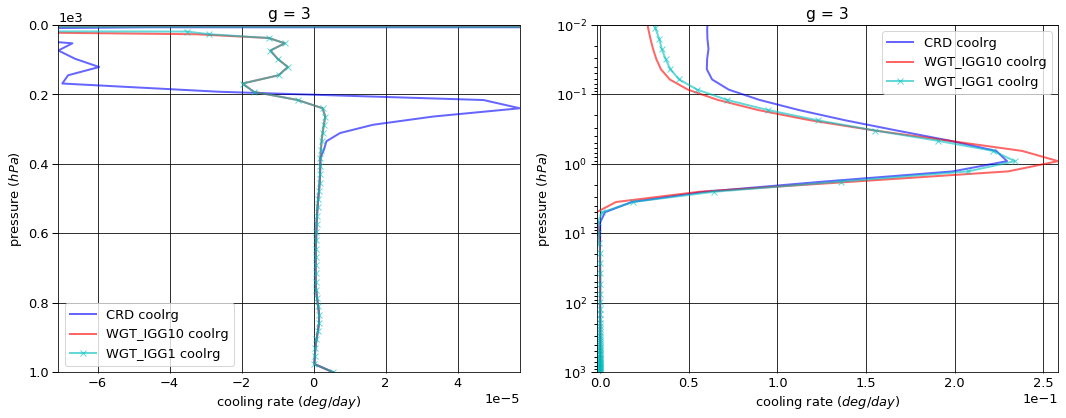

# Figure: cooling rate g-group 4

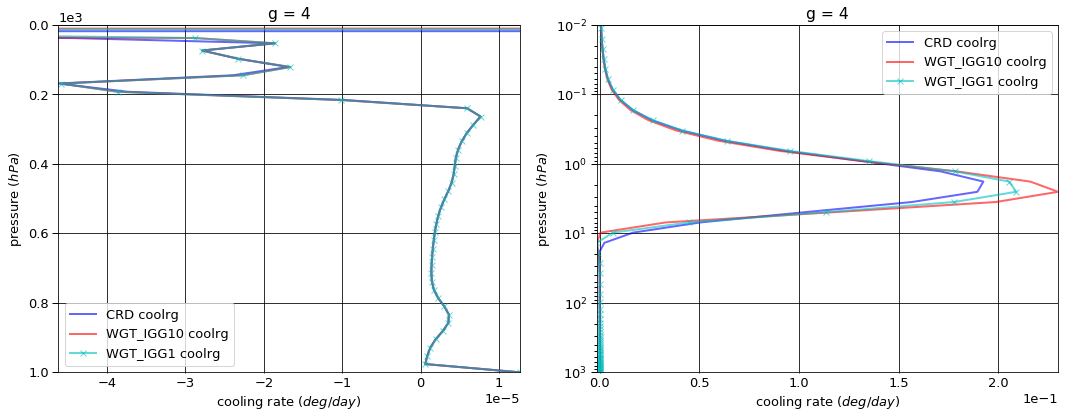

# Figure: cooling rate g-group 5

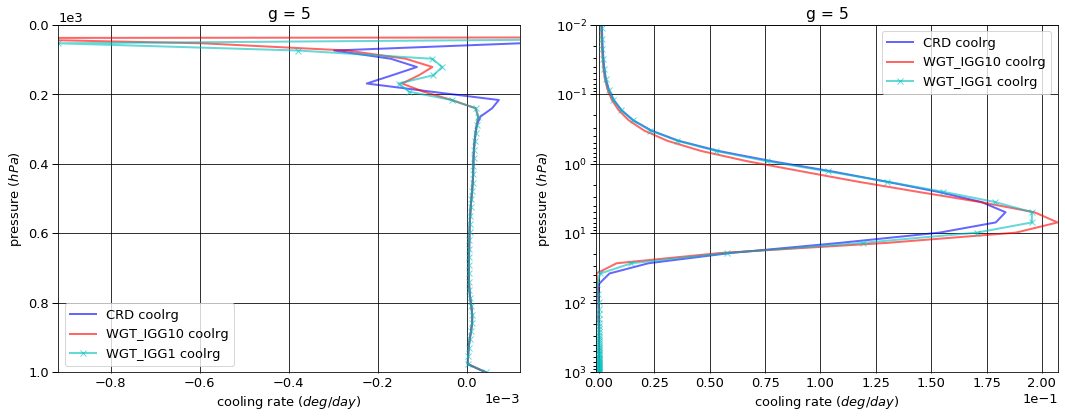

# Figure: cooling rate g-group 6

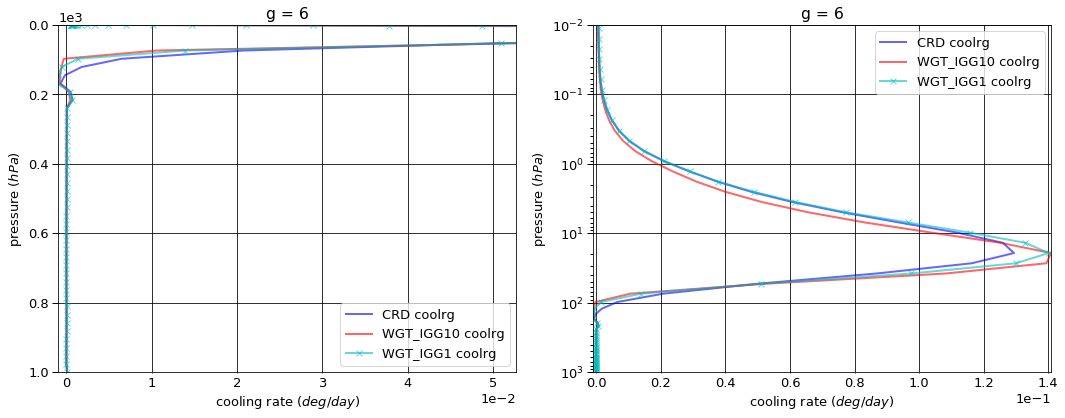

# Figure: cooling rate g-group 7

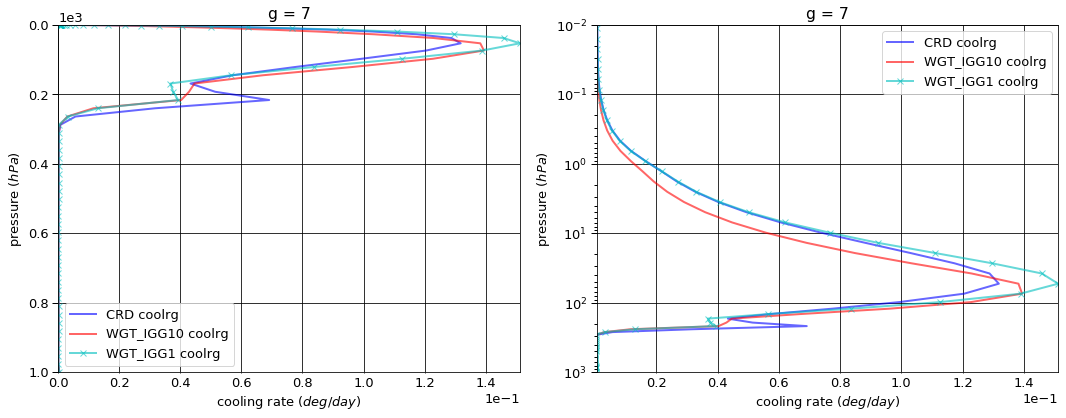

# Figure: cooling rate g-group 8

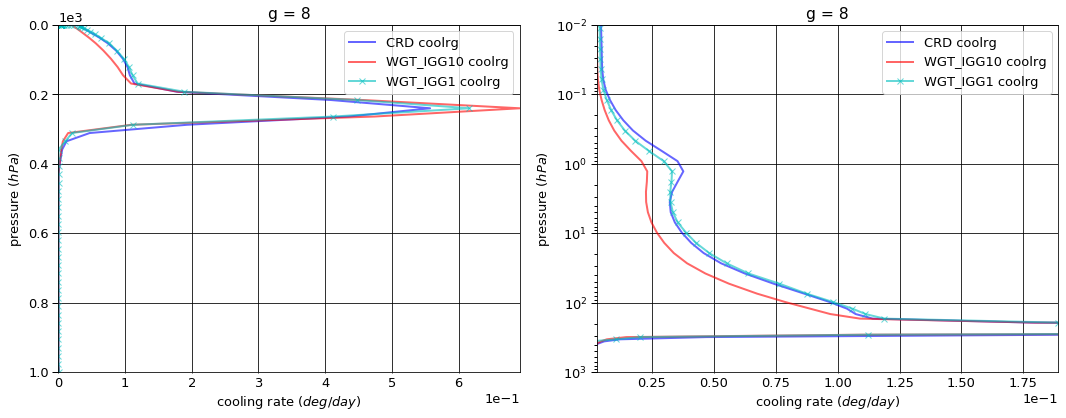

# Figure: cooling rate g-group 9

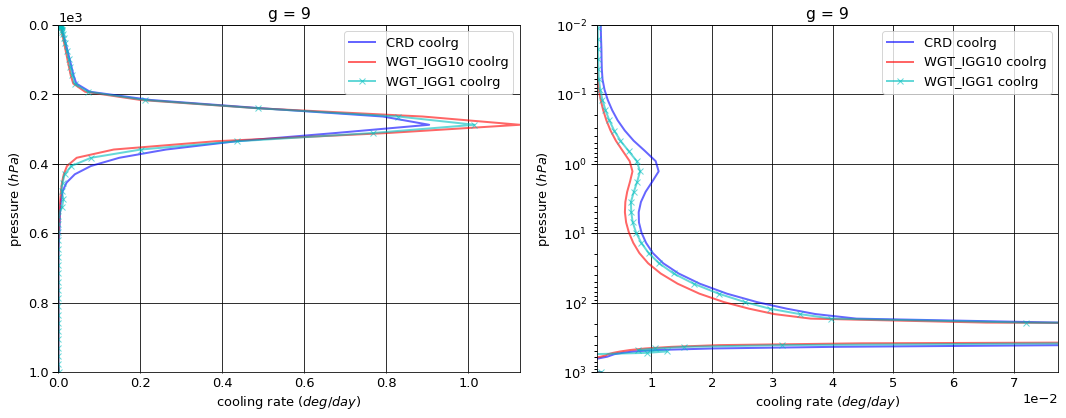

# Figure: cooling rate g-group 10

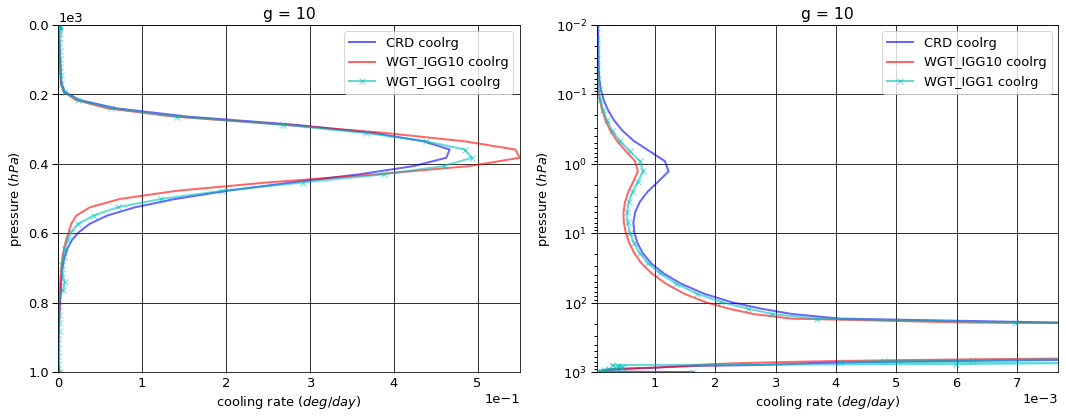

# Figure: cooling rate g-group total

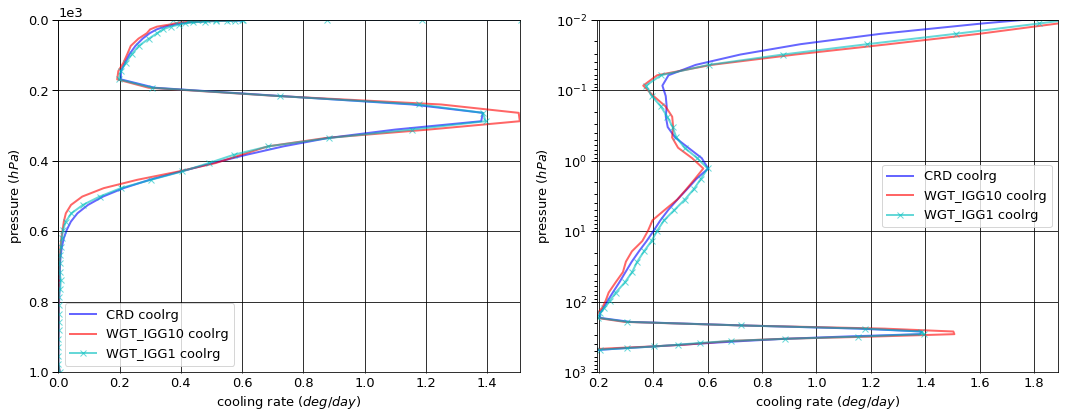

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007271   0.000000  -0.007271
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017996   0.000000  -0.017996
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.050264   0.000000  -0.050264
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.113820   0.000000  -0.113820
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.339652   0.000000  -0.339652
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.717453   0.000000  -0.717453
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.367531   0.000000  -2.367531
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.049878   0.000000  -7.049878
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.381325   0.000000 -12.381325
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.186593   0.000000 -11.186593
   1013.0   76    -15.782424  15.777909  -0.004515


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007171   0.000000  -0.007171
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017785   0.000000  -0.017785
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.051052   0.000000  -0.051052
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.115513   0.000000  -0.115513
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.342330   0.000000  -0.342330
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.719070   0.000000  -0.719070
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.348196   0.000000  -2.348196
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.037719   0.000000  -7.037719
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.295566   0.000000 -12.295566
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.098740   0.000000 -11.098740
   1013.0   76    -15.782424  15.777921  -0.004503


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007179   0.000000  -0.007179
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017992   0.000000  -0.017992
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.050757   0.000000  -0.050757
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.114822   0.000000  -0.114822
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.341849   0.000000  -0.341849
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.720980   0.000000  -0.720980
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.359825   0.000000  -2.359825
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.005155   0.000000  -7.005155
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.318941   0.000000 -12.318941
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.167148   0.000000 -11.167148
   1013.0   76    -15.782424  15.777921  -0.004503


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.004162e-04  0.000000e+00  1.004162e-04
   1013.0   76     0.000000e+00  0.000000e+00 -4.235165e-22
2  0.0      1      2.113510e-04  0.000000e+00  2.113510e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -7.876040e-04  0.000000e+00 -7.876040e-04
   1013.0   76     0.000000e+00 -6.938894e-18  0.000000e+00
4  0.0      1     -1.692160e-03  0.000000e+00 -1.692160e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -2.677830e-03  0.000000e+00 -2.677830e-03
   1013.0   76     0.000000e+00  0.000000e+00  1.355253e-20
6  0.0      1     -1.616780e-03  0.000000e+00 -1.616780e-03
   1013.0   76    -2.220446e-16 -2.220446e-16  0.000000e+00
7  0.0      1      1.933580e-02  0.000000e+00  1.933580e-02
   1013.0   76     0.000000e+00  4.440892e-16  0.000000e+00
8  0.0      1      1.215850e-02  0.000000e+00  1.215850e-02
   1013.0   76     0.000000e+00  0.000000e+00 -4.336809e-19
9  0.0      1      8.575900e-02  0.000000e+00  8.575900e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      8.785300e-02  0.000000e+00  8.785300e-02
   1013.0   76    -1.776357e-15  1.200000e-05  1.159770e-05


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      9.227160e-05  0.000000e+00  9.227160e-05
   1013.0   76     0.000000e+00  0.000000e+00 -4.235165e-22
2  0.0      1      4.480000e-06  0.000000e+00  4.480000e-06
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -4.929810e-04  0.000000e+00 -4.929810e-04
   1013.0   76     0.000000e+00 -6.938894e-18  0.000000e+00
4  0.0      1     -1.001470e-03  0.000000e+00 -1.001470e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1     -2.196960e-03  0.000000e+00 -2.196960e-03
   1013.0   76     0.000000e+00  0.000000e+00  1.355253e-20
6  0.0      1     -3.526960e-03  0.000000e+00 -3.526960e-03
   1013.0   76    -2.220446e-16 -2.220446e-16  0.000000e+00
7  0.0      1      7.705800e-03  0.000000e+00  7.705800e-03
   1013.0   76     0.000000e+00  4.440892e-16  0.000000e+00
8  0.0      1      4.472250e-02  0.000000e+00  4.472250e-02
   1013.0   76     0.000000e+00  0.000000e+00 -4.336809e-19
9  0.0      1      6.238400e-02  0.000000e+00  6.238400e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      1.944500e-02  0.000000e+00  1.944500e-02
   1013.0   76    -1.776357e-15  1.200000e-05  1.159770e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      4.811285
   1001.112500 75     0.000001
2  0.000312    1      0.322871
   1001.112500 75     0.000002
3  0.000312    1      0.053611
   1001.112500 75     0.000005
4  0.000312    1      0.000024
   1001.112500 75     0.000013
5  0.000312    1      0.000858
   1001.112500 75     0.000042
6  0.000312    1      0.000513
   1001.112500 75     0.000099
7  0.000312    1      0.000513
   1001.112500 75     0.000345
8  0.000312    1      0.003903
   1001.112500 75     0.000997
9  0.000312    1      0.001368
   1001.112500 75     0.001687
10 0.000312    1      0.000042
   1001.112500 75     0.001633


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      2.438445
   1001.112500 75     0.000001
2  0.000312    1      0.187375
   1001.112500 75     0.000002
3  0.000312    1      0.020738
   1001.112500 75     0.000005
4  0.000312    1      0.000021
   1001.112500 75     0.000013
5  0.000312    1      0.000620
   1001.112500 75     0.000042
6  0.000312    1      0.000476
   1001.112500 75     0.000099
7  0.000312    1      0.000330
   1001.112500 75     0.000345
8  0.000312    1      0.002337
   1001.112500 75     0.000997
9  0.000312    1      0.000777
   1001.112500 75     0.001687
10 0.000312    1      0.000023
   1001.112500 75     0.001628


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.966788
   1001.112500 75     0.000001
2  0.000312    1      0.217313
   1001.112500 75     0.000002
3  0.000312    1      0.024874
   1001.112500 75     0.000005
4  0.000312    1      0.000023
   1001.112500 75     0.000013
5  0.000312    1      0.000688
   1001.112500 75     0.000042
6  0.000312    1      0.000569
   1001.112500 75     0.000099
7  0.000312    1      0.000459
   1001.112500 75     0.000345
8  0.000312    1      0.003381
   1001.112500 75     0.000997
9  0.000312    1      0.000935
   1001.112500 75     0.001687
10 0.000312    1      0.000027
   1001.112500 75     0.001628


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.372841e+00
   1001.112500 75    -2.117582e-22
2  0.000312    1     -1.354966e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -3.287271e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -2.966034e-06
   1001.112500 75     1.694066e-21
5  0.000312    1     -2.372967e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -3.676680e-05
   1001.112500 75     1.355253e-20
7  0.000312    1     -1.829928e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.566368e-03
   1001.112500 75    -2.168404e-19
9  0.000312    1     -5.912702e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.850031e-05
   1001.112500 75    -4.747200e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.844497e+00
   1001.112500 75    -2.117582e-22
2  0.000312    1     -1.055581e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.873630e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.290000e-06
   1001.112500 75     1.694066e-21
5  0.000312    1     -1.696004e-04
   1001.112500 75     0.000000e+00
6  0.000312    1      5.577245e-05
   1001.112500 75     1.355253e-20
7  0.000312    1     -5.462777e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -5.228304e-04
   1001.112500 75    -2.168404e-19
9  0.000312    1     -4.327001e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.476515e-05
   1001.112500 75    -4.747200e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.231785,0.000000,-34.231785
1013.0,76,-51.073430,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.033141,0.000000,-34.033141
1013.0,76,-51.073430,51.060099,-0.013331



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.104649,0.000000,-34.104649
1013.0,76,-51.073430,51.060099,-0.013331



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.198644,0.000000,0.198644
1013.0,76,0.000000,0.000012,0.000012



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.127136,0.000000,0.127136
1013.0,76,0.000000,0.000012,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.194989
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.651143
1001.112500,75,0.004820



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3.215058
1001.112500,75,0.004820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.543846
1001.112500,75,-0.000005



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.979931
1001.112500,75,-0.000005


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000266,0.000247
2,0.000500,0.000502
3,0.001391,0.001208
4,0.003156,0.002844
5,0.011406,0.009518
6,0.025547,0.022349
7,0.093094,0.077651
8,0.256141,0.222367
9,0.383641,0.363218


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000266,0.000247,0.000266,0.000247,1.0
2,1.309690e-17,0.119479,0.000500,0.000502,0.000766,0.000749,1.0
3,1.564810e-18,0.119479,0.001391,0.001208,0.002156,0.001957,1.0
4,4.601703e-18,2.940742,0.003156,0.002844,0.005313,0.004801,30.0
5,5.682550e-19,0.123488,0.011406,0.009518,0.016719,0.014319,30.0
6,6.154553e-19,1.083062,0.025547,0.022349,0.042266,0.036668,300.0
7,7.853808e-20,0.127610,0.093094,0.077651,0.135359,0.114319,300.0
8,1.002222e-20,0.127610,0.256141,0.222367,0.391500,0.336686,300.0
9,1.278933e-21,0.127610,0.383641,0.363218,0.775141,0.699904,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
